In [33]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import pandas as pd
import array
from scipy.interpolate import griddata
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.optimize import root
import seaborn as sns
from statistics import mode

# Geospatial data manipulation and raster operations
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr

from shapely.geometry import Point

# Electromagnetic induction data inversion package
from emagpy import Problem

from PM import *
%matplotlib inline

In [34]:
# 0.3: Get dataset location
# -------------------------
# store dataset URL's as string variables
#FDEM_surveydata = 'C:/Users/gmendoza/OneDrive - UGent/Documentos/PhD/EM case survey/Code_EM_survey_case/survey_Lam72.csv'
#FDEM_transect = 'C:/Users/gmendoza/OneDrive - UGent/Documentos/PhD/EM case survey/Code_EM_survey_case/ERT_PH_set.csv'
#samples = 'C:/Users/gmendoza/OneDrive - UGent/Documentos/PhD/EM case survey/Code_EM_survey_case/samples_combined.csv'
FDEM_surveydata = 'C:/Users/mendo/OneDrive - UGent/Documentos/PhD/EM case survey/Data/Proefhoeve/survey_042022/survey_Lam72.csv'
FDEM_transect = 'C:/Users/mendo/OneDrive - UGent/Documentos/PhD/EM case survey/Code_EM_survey_case/ERT_PH_set.csv'
samples = 'C:/Users/mendo/OneDrive - UGent/Documentos/PhD/EM case survey/Data/Proefhoeve/samples_combined.csv'

# URL for grid masking file
blank_json = 'https://users.ugent.be/~pjdsmedt/ESS2023/blank.json'

# Create dataframes from datasets
'''
Import datasets as dataframes
-----------------------------
    - df = dataframe with the full FDEM dataset
    - dt = dataframe with the FDEM transect
    - ds = datasframe with the sample data (including analytical data)
    - blank = geojson (polygon) outlining survey extent
'''
df = pd.read_csv(FDEM_surveydata, sep=',', header=0)
dt = pd.read_csv(FDEM_transect, sep=',', header=0, encoding='cp1252')
ds = pd.read_csv(samples, sep=',', header=0, encoding='cp1252')
blank_in = gpd.read_file(blank_json)
blank = blank_in.to_crs('EPSG:31370')
ds.columns

Index(['Unnamed: 0', 'x', 'y', 'z', 't', 'HCP0.5', 'PRP0.6', 'HCP1.0',
       'PRP1.1', 'HCP2.0', 'PRP2.1', 'HCP0.5_inph', 'PRP0.6_inph',
       'HCP1.0_inph', 'PRP1.1_inph', 'HCP2.0_inph', 'PRP2.1_inph', 'name',
       'depth', 'x_clhs', 'y_clhs', 'ph-eau', 'CEC', 'clay', 'silt', 'sand',
       'TOC', 'humus', 'bd', 'vwc', 'copeky', 'temp', 'rperm', 'iperm'],
      dtype='object')

## Preprocesingn

In [35]:
ds_c = ds.copy()
# Caclculate Bulk EC from HydraProbe data at 50Mhz
offset = 4
water_perm = 80
ds_c['bulk_ec_hp'] = logsdon(50e6, ds_c.rperm, ds_c.iperm)

# Caclculate Bulk EC from HydraProbe data at 0 Hz
def objective_func_ec_dc(bulk_ec_dc, frequency_ec, bulk_ec):
    return (LongmireSmithEC(bulk_ec_dc, frequency_ec) - bulk_ec)**2
bulk_ec_dc_hp = []

for i in range(len(ds_c.bulk_ec_hp.values)):
    res = minimize(objective_func_ec_dc, 0.05, args=(50e6, ds_c.bulk_ec_hp[i]), bounds=[(0, 1)])
    bulk_ec_dc_hp.append(np.nan if np.isnan(res.fun) else round(res.x[0], 5) )

ds_c['bulk_ec_dc_hp'] = bulk_ec_dc_hp

# Caclculate Water EC from HydraProbe data at 50Mhz
ds_c['water_ec_hp'] = Hilhorst(ds_c.bulk_ec_hp, ds_c.rperm, water_perm, offset)
ds_c['iperm_water'] = ds_c.water_ec_hp/(50e6*2*pi*epsilon_0)

# Caclculate Aparent Bulk EC from EMI at 0 Hz in S/m
EC_columns = ['HCP0.5', 'PRP0.6', 'HCP1.0', 'PRP1.1', 'HCP2.0', 'PRP2.1'] 
for col in EC_columns:
    EC_DC = []
    for i in range(len(ds_c[col].values)):
        res = minimize(objective_func_ec_dc, 0.05, args=(9e3, ds_c[col][i]/1000), bounds=[(0, 1)])
        EC_DC.append(np.nan if np.isnan(res.fun) else round(res.x[0], 5) )

    ds_c[col+'_DC'] = EC_DC

In [36]:
results_r2 = pd.DataFrame(columns=['Aparent_HCP', 'Aparent_PRP', 'Inverted', 'Inverted_ERT'],
                  index=range(0, 2))

results_rmse = pd.DataFrame(columns=['Aparent_HCP', 'Aparent_PRP', 'Inverted', 'Inverted_ERT'],
                  index=range(0, 2))

## Inversion of DC EMI data

100%|██████████| 30/30 [00:03<00:00,  7.61it/s] 


   Finished inversion


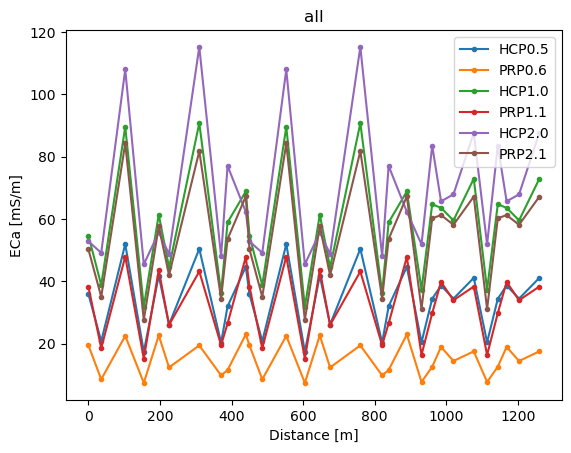

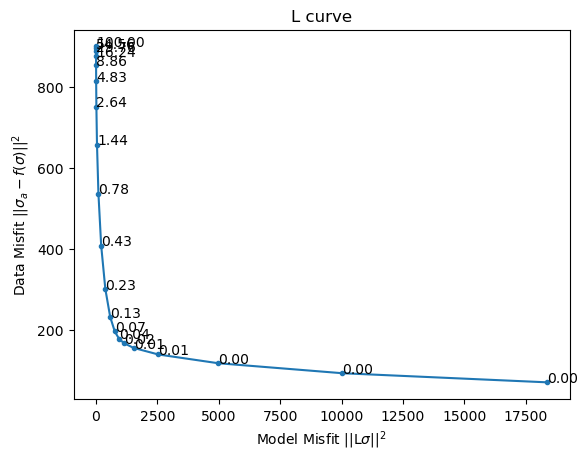

In [37]:
#depths_in = [0.1, 0.5, 0.8, 1.5]
depths_in = [0.4, 0.8]

# Set pdf name for exporting plot
pdf_name = 'Modelled_EC_profiles.pdf'

# ******************************************************************** #
# Create an inversion problem object to solve with EMagPy

sampling_path = samples
sample_transect = Problem()
sample_transect.createSurvey(sampling_path, freq=9e3,hx=0.165,unit='ECa')
sample_transect.setInit(depths0=depths_in)
sample_transect.show()
sample_transect.lcurve()

# Run the inversion
sample_transect.invert( alpha=0.03, njobs=-1) # FSIQ, alpha  check forwardModel='FSeq',
print('   Finished inversion')

# ----------------------------------------------------------------------
# Plotting and exporting the EC profiles figure as a pdf
# ----------------------------------------------------------------------

# Putting the results in a dataframe, and concatenate with analytical data.
depth_values = sample_transect.depths[0][0]
layer_cols = ['EC_{:.2f}'.format(d) for d in depth_values] + ['EC_end']
data = np.c_[sample_transect.surveys[0].df[['x', 'y']].values, 
             sample_transect.models[0]]

ds_inv = pd.DataFrame(data, columns=['x', 'y'] + layer_cols)
selected_columns_ds = pd.concat([ds_c.iloc[:, 3:11], ds_c.iloc[:, 17:]], axis=1)

ds_all = pd.concat([ds_inv, selected_columns_ds], axis=1)
#ds_all = ds_all.dropna()

unique_sample_ids = ds_all['name'].unique()

# Calculate number of rows and columns for the subplot
subplot_rows = 3
subplot_cols = 5

# Get axis limits
global_x_min = ds_all[layer_cols].min().min()
global_x_max = ds_all[layer_cols].max().max()

csv_filename = 'inverted_samples_PH.csv'
ds_all.to_csv(csv_filename)

## 

In [38]:
# Calculate the Bulk EC DC inverted at suitable depth based on invertion layers.
bulk_ec_dc_010 = []
for i in range(len(ds_all.bulk_ec_hp.values)):
    res = minimize(objective_func_ec_dc, 0.05, args=(9e3, ds_all['EC_0.40'][i]/1000), bounds=[(0, 1)])
    bulk_ec_dc_010.append(np.nan if np.isnan(res.fun) else round(res.x[0], 5) )

ds_all['bulk_ec_dc_010'] = bulk_ec_dc_010
ds_all_10cm = ds_all.loc[ds_all['depth']==10].reset_index(drop=True)

bulk_ec_dc_050 = []
for i in range(len(ds_all.bulk_ec_hp.values)):
    res = minimize(objective_func_ec_dc, 0.05, args=(9e3, ds_all['EC_0.80'][i]/1000), bounds=[(0, 1)])
    bulk_ec_dc_050.append(np.nan if np.isnan(res.fun) else round(res.x[0], 5) )

ds_all['bulk_ec_dc_050'] = bulk_ec_dc_050
ds_all_50cm = ds_all.loc[ds_all['depth']==50].reset_index(drop=True)

ds_all['bulk_ec_dc_inv'] = [ds_all.bulk_ec_dc_010[i] if ds_all.depth[i] == 10 else ds_all.bulk_ec_dc_050[i] for i in range(len(ds_all.vwc))]

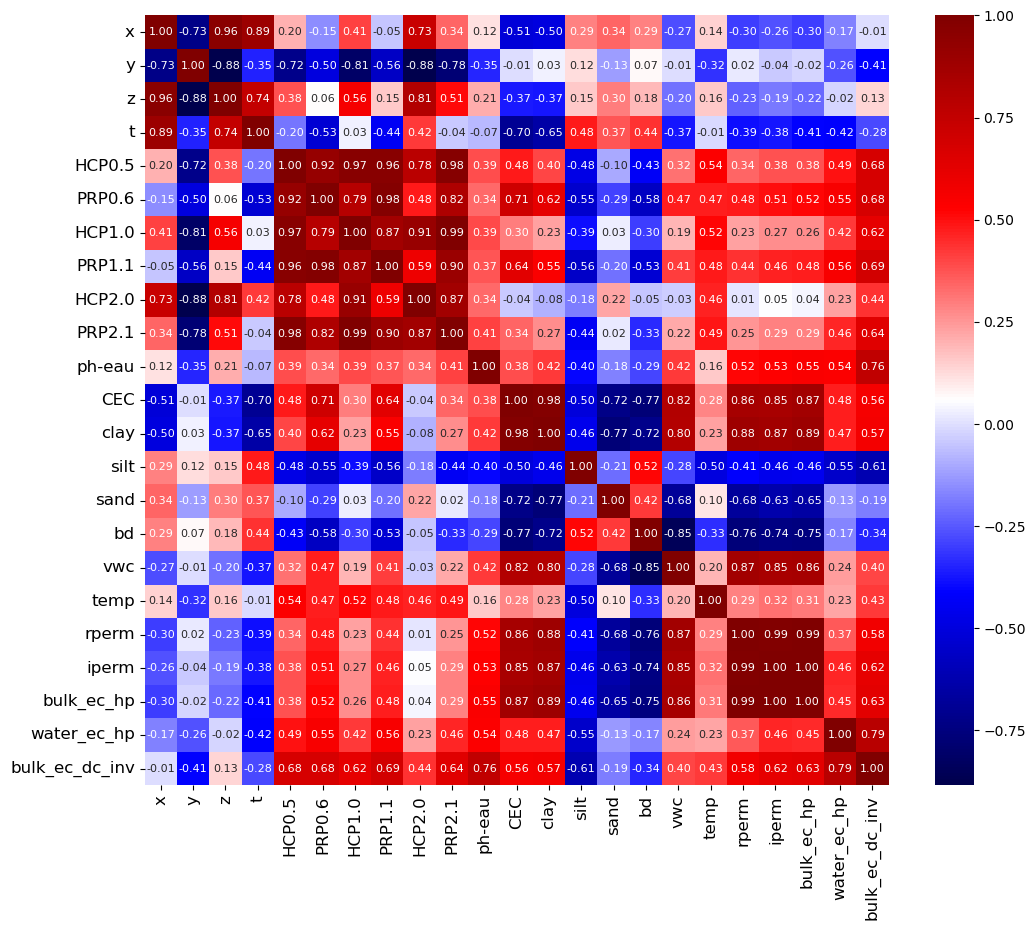

In [39]:
ds_f = ds_all[['x', 'y', 'z', 't', 'HCP0.5', 'PRP0.6', 'HCP1.0',
       'PRP1.1', 'HCP2.0', 'PRP2.1', 'ph-eau', 'CEC', 'clay', 'silt', 'sand',
        'bd', 'vwc', 'temp', 'rperm', 'iperm', 'bulk_ec_hp', 'water_ec_hp', 'bulk_ec_dc_inv']]

# Setting the figure size
plt.figure(figsize=(12, 10))

# Plotting correlation heatmap with annotations
dataplot = sns.heatmap(ds_f.corr(), cmap="seismic", annot=True, fmt=".2f", annot_kws={"size": 8})

dataplot.tick_params(axis='both', which='major', labelsize=12)

# Rotating y-axis labels for better visualization
dataplot.set_yticklabels(dataplot.get_yticklabels(), rotation=0)

# Setting the label size for x and y axes
dataplot.set_xlabel(dataplot.get_xlabel(), fontsize=14)
dataplot.set_ylabel(dataplot.get_ylabel(), fontsize=14)

plt.show()

## Deterministic modelling

In [40]:
clay_50cm = np.mean(ds_all.clay[ds_all['depth']==50])
clay_10cm = np.mean(ds_all.clay[ds_all['depth']==10])
bd_50cm = np.mean(ds_all.bd[ds_all['depth']==50])
bd_10cm = np.mean(ds_all.bd[ds_all['depth']==10])
water_ec_hp_50cm = np.mean(ds_all.water_ec_hp[ds_all['depth']==50])
water_ec_hp_10cm = np.mean(ds_all.water_ec_hp[ds_all['depth']==10])

# Defining minimization function to obtain water using Fu
def objective_func_wat(x, clay, bulk_density, particle_density, water_ec, solid_ec, dry_ec, sat_ec, EC):
    return (Fu(x, clay, bulk_density, particle_density, water_ec, solid_ec, dry_ec, sat_ec) - EC)**2

def calculate_water(ds, col):
    wat = []
    for dc in ds[col]:
        index = ds.index[ds[col] == dc][0]
        if ds.depth[index] == 50:
            res = minimize(objective_func_wat, 0.15, args=(clay_50cm, bd_50cm, 2.65, water_ec_hp_50cm, 
                                                       0, np.nan, np.nan, dc), bounds=[(0, .65)])
        else:
            res = minimize(objective_func_wat, 0.15, args=(clay_10cm, bd_10cm, 2.65, water_ec_hp_10cm, 
                                                       0, np.nan, np.nan, dc), bounds=[(0, .65)])            
        wat.append(np.nan if np.isnan(res.fun) else round(res.x[0], 3))

    r2_val = round(r2_score(ds.vwc.values, wat), 2)
    rmse_val = round(RMSE(ds.vwc.values, wat), 2)
    return wat, r2_val, rmse_val

def plot_results(df, actual, predicted, r2_val, rmse_val, scale, title):
    
    fig, axes = plt.subplots(figsize=[7, 6])
    ss = 200
    
    # Create a colormap
    cmap = plt.cm.Reds

    # Loop through each point and plot with appropriate marker
    for i, (x, y, s) in enumerate(zip(actual, predicted, scale)):
        if ~(np.isnan(x) or np.isnan(y) or np.isnan(s)):
            if df['depth'].iloc[i] == 50:
                marker_style = 'D'
            else:
                marker_style = 'o'
            axes.scatter(x, y, s=ss, alpha=0.8, c=[s], cmap=cmap, vmin=0, vmax=65, marker=marker_style)

    # Create a dummy scatter plot to use its colormap
    dummy_scatter = plt.scatter([], [], c=[], cmap=cmap, vmin=0, vmax=65)
    cbar = plt.colorbar(dummy_scatter, ax=axes)

    axes.plot([0, 0.6], [0, 0.6], color='black', label=f'R2 = {r2_val}; RMSE = {rmse_val}')
    axes.set_xlabel("Observed wat")
    axes.set_ylabel("Predicted wat")
    axes.set_title(title)
    axes.legend()
    axes.grid(True)
    axes.set_xlim([0, 0.6])
    axes.set_ylim([0, 0.6])
    plt.show()

col HCP0.5_DC wat [0.336, 0.224, 0.435, 0.195, 0.374, 0.267, 0.426, 0.22, 0.309, 0.392, 0.336, 0.224, 0.435, 0.195, 0.374, 0.267, 0.426, 0.22, 0.309, 0.392, 0.146, 0.227, 0.249, 0.227, 0.262, 0.146, 0.227, 0.249, 0.227, 0.262]


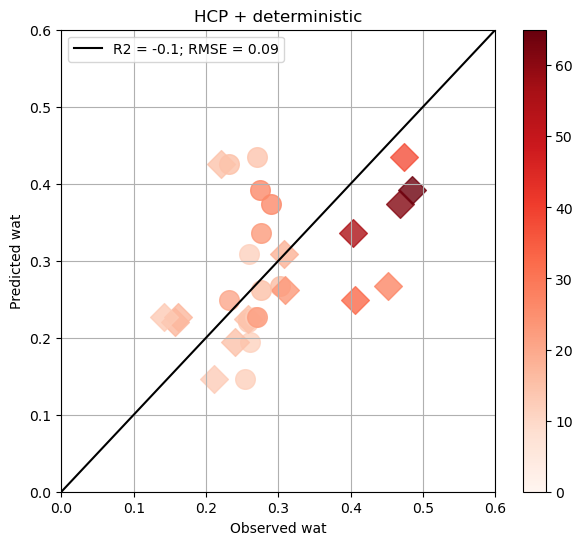

col PRP1.1_DC wat [0.351, 0.205, 0.411, 0.175, 0.386, 0.266, 0.383, 0.214, 0.269, 0.411, 0.351, 0.205, 0.411, 0.175, 0.386, 0.266, 0.383, 0.214, 0.269, 0.411, 0.12, 0.201, 0.255, 0.224, 0.248, 0.12, 0.201, 0.255, 0.224, 0.248]


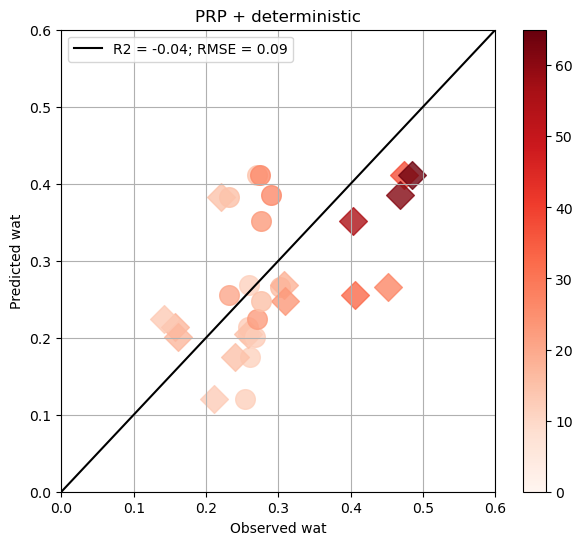

col bulk_ec_dc_inv wat [0.387, 0.161, 0.377, 0.115, 0.442, 0.264, 0.311, 0.176, 0.199, 0.46, 0.338, 0.243, 0.478, 0.204, 0.373, 0.283, 0.471, 0.238, 0.339, 0.41, 0.228, 0.368, 0.379, 0.359, 0.407, 0.118, 0.221, 0.378, 0.304, 0.314]


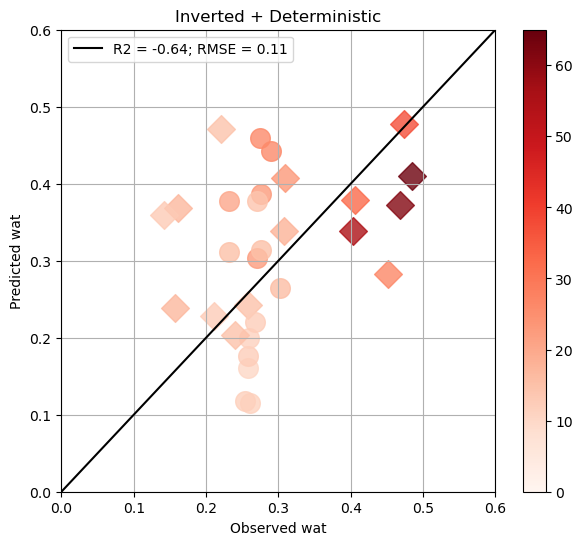

In [41]:
cols_and_titles = [
    ('HCP0.5_DC', 'HCP + deterministic', 'Aparent_HCP'),
    ('PRP1.1_DC', 'PRP + deterministic', 'Aparent_PRP'), 
    ('bulk_ec_dc_inv', 'Inverted + Deterministic', 'Inverted')]

target = ds_all['vwc']
for col, title, result_col in cols_and_titles:
    if col:
        wat, r2_val, rmse_val = calculate_water(ds_all, col)
        results_r2[result_col][1] = r2_val
        results_rmse[result_col][1] = rmse_val
        print('col', col, 'wat', wat)
        plot_results(ds_all, target, wat, r2_val, rmse_val, ds_all.clay, title)

## Stochastic

In [53]:

def stochastic_poly(df, feature_columns, Y, n=10, iters=1000, round_n=3):
    X = df[feature_columns]
    ypred_train_best, ypred_test_best, R2_train_t_best, R2_test_t_best, RMSE_train_t_best, RMSE_test_t_best = [], [], [], [], [], []

    for i in range(iters):
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=i)
        LinReg = LinearRegression()
        ypred_train_, ypred_test_, R2_train_t_, R2_test_t_, RMSE_train_t_, RMSE_test_t_ = [], [], [], [], [], []

        for k in range(n):
            poly = PolynomialFeatures(degree=k)
            poly.fit(X_train)
            Xt_train = poly.transform(X_train)/1000
            Xt_test = poly.transform(X_test)/1000

            LinReg.fit(Xt_train, y_train)
            ypred_train = LinReg.predict(Xt_train)
            ypred_test = LinReg.predict(Xt_test)

            R2_train_t = r2_score(y_train, ypred_train)
            R2_test_t = r2_score(y_test, ypred_test)
            RMSE_train_t = RMSE(y_train, ypred_train)
            RMSE_test_t = RMSE(y_test, ypred_test)

            ypred_train_.append(ypred_train)
            ypred_test_.append(ypred_test)
            R2_train_t_.append(R2_train_t)
            R2_test_t_.append(R2_test_t)
            RMSE_train_t_.append(RMSE_train_t)
            RMSE_test_t_.append(RMSE_test_t)

        ypred_train_best.append(ypred_train_)
        ypred_test_best.append(ypred_test_)
        R2_train_t_best.append(R2_train_t_)
        R2_test_t_best.append(R2_test_t_)
        RMSE_train_t_best.append(RMSE_train_t_)
        RMSE_test_t_best.append(RMSE_test_t_)

    rmse_test_n1 = [inner_list[0] for inner_list in RMSE_test_t_best]
    rmse_test_n2 = [inner_list[1] for inner_list in RMSE_test_t_best]
    rmse_test_n3 = [inner_list[2] for inner_list in RMSE_test_t_best]
    rmse_test_n4 = [inner_list[3] for inner_list in RMSE_test_t_best]

    rmse_means = [np.mean(rmse_test_n1), np.mean(rmse_test_n2), np.mean(rmse_test_n3), np.mean(rmse_test_n4)]
    print('r2_means', rmse_means)
    best_n = rmse_means.index(np.max(rmse_means))
    return best_n, round(np.mean([inner_list[best_n] for inner_list in R2_test_t_best]), round_n), round(np.mean([inner_list[best_n] for inner_list in R2_train_t_best]), round_n), round(np.mean([inner_list[best_n] for inner_list in RMSE_test_t_best]), round_n), round(np.mean([inner_list[best_n] for inner_list in RMSE_train_t_best]), round_n)                         


def bars_plot(feature_sets, test_errors_summary, train_errors_summary):
    fig, ax = plt.subplots()
    width = 0.35  # the width of the bars

    x = np.arange(len(feature_sets))
    rects1 = ax.bar(x - width/2, test_errors_summary, width, color = 'red', label='Test')
    rects2 = ax.bar(x + width/2, train_errors_summary, width, color = 'blue', label='Train')

    ax.axhline(0, color='grey', linewidth=0.8)
    ax.set_ylabel('Scores')
    ax.set_xticks(range(len(test_errors_summary)), feature_sets, rotation = 15)
    ax.set_ylim(0, 1)
    ax.legend()
    fig.tight_layout()

    plt.show()
    plt.savefig("stoch_wat", dpi=200)                    

r2_means [0.09100806615832706, 0.08350046501778106, 0.09752821312081392, 0.16884091111852204]
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 3 -13.027 0.511 0.169 0.062 ['HCP0.5', 'HCP1.0']
r2_means [0.09100806615832706, 0.08356738035536859, 0.1002754652323588, 0.17132972514581718]
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 3 -11.759 0.551 0.171 0.059 ['HCP0.5', 'HCP2.0']
r2_means [0.09100806615832706, 0.08403530646314394, 0.10115447944055075, 0.14112154784960018]
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 3 -6.487 0.566 0.141 0.058 ['HCP2.0', 'HCP1.0']
r2_means [0.09100806615832706, 0.08804063391373908, 0.12975384835429424, 0.393380426274652]
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set: 3 -84.802 0.659 0.393 0.051 ['HCP0.5', 'HCP1.0', 'HCP2.0']


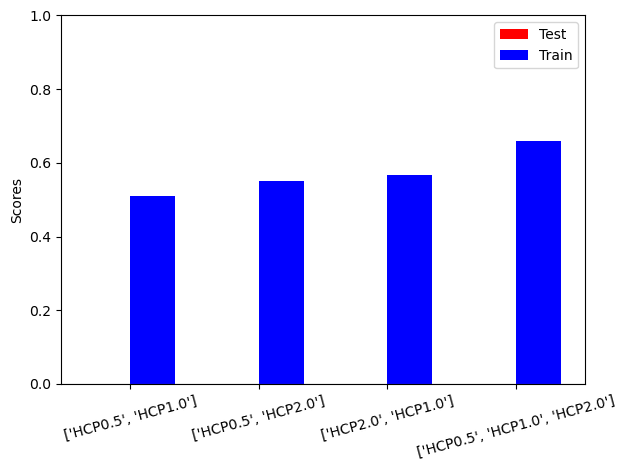

<Figure size 640x480 with 0 Axes>

In [54]:
# For HCP
target = ds['vwc']

feature_sets = [
    ['HCP0.5', 'HCP1.0'],
    ['HCP0.5', 'HCP2.0'],
    ['HCP2.0', 'HCP1.0'],
    ['HCP0.5', 'HCP1.0', 'HCP2.0'],
]
test_r2_summary, train_r2_summary, test_rmse_summary = [], [], []

for feature_set in feature_sets:
    best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol = stochastic_poly(ds, feature_set, target)
    print('best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set:', best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set)
    test_r2_summary.append(R2_test_pol)
    test_rmse_summary.append(RMSE_test_pol)
    train_r2_summary.append(R2_train_pol)

bars_plot(feature_sets, test_r2_summary, train_r2_summary)

results_r2.Aparent_HCP[0] = np.max(test_r2_summary)
results_rmse.Aparent_HCP[0] = np.max(test_rmse_summary)


In [44]:
# For PRP
target = ds['vwc']

best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol = stochastic_poly(ds, ['PRP0.6', 'PRP1.1'], target)
print(best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol)
#pred = np.concatenate((nan_array, y_hat_test_t_))
#ds_clay = np.concatenate((nan_array, ds.clay[20:]))
r2_apPRP_sc = R2_test_pol
rmse_apPRP_sc = RMSE_test_pol
results_r2.Aparent_PRP[0] = r2_apPRP_sc
results_rmse.Aparent_PRP[0] = rmse_apPRP_sc
#plot_results(ds, target,pred, r2_apPRP_sc, rmse_apPRP_sc, ds_clay, 'PRP + stochastic')

r2_test_n1 [-0.24701379857535644, -0.02692709136725724, -0.0038922301137016557, -0.362068627104315, -0.012968101726898995, -0.20905221738994806, -0.0008297118030813344, -0.6879020834215543, -0.16940566737874452, -0.0020661339114120825, -0.13982345459072976, -0.002881532045675206, -0.0408860017171635, -0.0008095119905568993, -0.040307612998539355, -0.2795538851564787, -0.141740528147273, -0.04794056382341694, -0.1762200411677204, -1.0679350891867139, -0.1541474780932146, -0.01813696169289858, -0.1014959587819031, -0.00437324921396276, -0.1699555553619958, -0.43196873694027094, -0.18322138992301262, -0.0036893367406261035, -0.6145851204337016, -0.6048253711639802, -0.07439221085789893, -0.09253400189276961, -0.014564235105742007, -0.09466773270843798, -0.1867004398595462, -0.002424289692877446, -0.14720551209004795, -2.0099869587928882, -0.057851616216265445, -0.03256091545880713, -0.1715543232610759, -0.09933860510453552, -0.0022063515321977256, -1.8262689698955725e-05, -0.1222654847103

In [45]:
# For Inverted
target = ds['vwc']

best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol = stochastic_poly(ds_all, ['bulk_ec_dc_inv'], target)
print(best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol)
#pred = np.concatenate((nan_array, y_hat_test_t_))
#ds_clay = np.concatenate((nan_array, ds.clay[20:]))
r2_apINV_sc = R2_test_pol
rmse_apINV_sc = RMSE_test_pol
results_r2.Inverted[0] = r2_apINV_sc
results_rmse.Inverted[0] = rmse_apINV_sc
#plot_results(ds, target, pred, r2_apINV_sc, rmse_apINV_sc, ds_clay, 'Inverted + stochastic')

r2_test_n1 [-0.24701379857535644, -0.02692709136725724, -0.0038922301137016557, -0.362068627104315, -0.012968101726898995, -0.20905221738994806, -0.0008297118030813344, -0.6879020834215543, -0.16940566737874452, -0.0020661339114120825, -0.13982345459072976, -0.002881532045675206, -0.0408860017171635, -0.0008095119905568993, -0.040307612998539355, -0.2795538851564787, -0.141740528147273, -0.04794056382341694, -0.1762200411677204, -1.0679350891867139, -0.1541474780932146, -0.01813696169289858, -0.1014959587819031, -0.00437324921396276, -0.1699555553619958, -0.43196873694027094, -0.18322138992301262, -0.0036893367406261035, -0.6145851204337016, -0.6048253711639802, -0.07439221085789893, -0.09253400189276961, -0.014564235105742007, -0.09466773270843798, -0.1867004398595462, -0.002424289692877446, -0.14720551209004795, -2.0099869587928882, -0.057851616216265445, -0.03256091545880713, -0.1715543232610759, -0.09933860510453552, -0.0022063515321977256, -1.8262689698955725e-05, -0.1222654847103

In [46]:
results_rmse

,Aparent_HCP,Aparent_PRP,Inverted,Inverted_ERT
0,0.091,0.091,0.085,NaN
1,0.09,0.09,0.11,NaN


In [47]:
results_r2

,Aparent_HCP,Aparent_PRP,Inverted,Inverted_ERT
0,-0.181,-0.181,-0.06,NaN
1,-0.1,-0.04,-0.64,NaN


In [48]:
####################### 10 cm ##########################

#wat = []
# Calculating water
#for i in range(len(ds_all_10cm.bulk_ec_dc_010)):
#    res = minimize(objective_func_wat, 0.15, args=(ds_all_10cm.clay.mean(), ds_all_10cm.bd.mean(), 2.65, 
#                    ds_all_10cm.water_ec_hp.mean(), 0, np.nan, np.nan, ds_all_10cm.bulk_ec_dc_010[i]), bounds=[(0, .65)] )
#    wat.append(np.nan if np.isnan(res.fun) else round(res.x[0], 3) )

#r2_10cm = round(r2_score(ds_all_10cm.vwc.values, wat), 3)
#rmse_10cm = round(rmse(ds_all_10cm.vwc.values, wat), 3)

####################### 50 cm ##########################

# Calculating water
#for i in range(len(ds_all_50cm.bulk_ec_dc_050)):
##    res = minimize(objective_func_wat, 0.15, args=(ds_all_50cm.clay.mean(), ds_all_50cm.bd.mean(), 2.65, 
#                    ds_all_50cm.water_ec_hp.mean(), 0, np.nan, np.nan, ds_all_50cm.bulk_ec_dc_050[i]), bounds=[(0, .65)] )
#    wat.append(np.nan if np.isnan(res.fun) else round(res.x[0], 3) )

#r2_50cm = round(r2_score(ds_all_50cm.vwc.values, wat[15:]), 3)
#rmse_50cm = round(rmse(ds_all_50cm.vwc.values, wat[15:]), 3)

#r2_inv_dt = round(r2_score(ds_all.vwc.values, wat), 3)
#rmse_inv_dt = round(rmse(ds_all.vwc.values, wat), 3)
#print(r2_inv_dt, rmse_inv_dt)